# url: https://datawokagaku.com/lightgbm/#google_vignette

# LightGBMを超わかりやすく解説(理論+実装)【機械学習入門33】

前回の記事で決定木の勾配ブースティングアルゴリズムであるXGBoostを紹介しましたが，今回は同じ決定木の勾配ブースティングの別のアルゴリズムであるLightGBMについて解説します．

LightGBMはXGBoostが発表されてから2~3年後に発表され，今やXGBoostよりも高速で高精度なアルゴリズムとして認識され，XGBoostに代わる最強のアルゴリズムの一つとなっています．

XGBoostと同じ決定木の勾配ブースティングをベースにしているので，前回の記事の内容が理解できれば割と簡単にLightGBMも理解できると思います．

コンペ上位では常連となっているLightGBMですが，割と新しいアルゴリズムであることもありまだまだ情報が少ないように思います．

本記事では包括的に超分かりやすく理論を解説し，さらにPythonでの実装も紹介するので，是非この機会に習得してしまいましょう！

## LightGBMとは？
LightGBM(Light Gradient Boosting Machine)は，Microsoft Research(MSR)を中心としたチームから発表された機械学習アルゴリズムです．

XGBoostと同じ決定木の勾配ブースティングアルゴリズムであり，XGBoostに比べ高速(=軽い: Light)であることが特徴です．

2016年に発表されて以来Kaggleなどの様々なコンペの上位モデルで採用されていて，間違いなく”最強のアルゴリズム”の一つと言えます．

前回の記事で解説した通り，XGBoostなどの従来の決定木の勾配ブースティングは非常に高い精度が期待できるんですが，決定木を作る際の“分割”に時間がかかるのが難点でした(決定木のアルゴリズムについては第28回を参照ください)

例えば，連続値の特徴量において損失が最小になるように二分割するには，あらかじめソートされたデータに対して，どこで分割するのがいいのかを一つ一つ計算し最終的な分岐点を決めるので，データの数だけ計算量が増えていきます．

一つ一つの決定木をなるべく精度を落とさずにどのように高速に構築できるのか？

この課題に取り組んだ結果生まれたのがLightGBMなんです．

## 決定木の勾配ブースティング
前回のXGBoostの記事で解説しましたが，改めて決定木の勾配ブースティング(GBDT: Gradient Boosting Decision Tree)がどういうものだったか見てみましょう．(ブースティングについては第30回を参照)

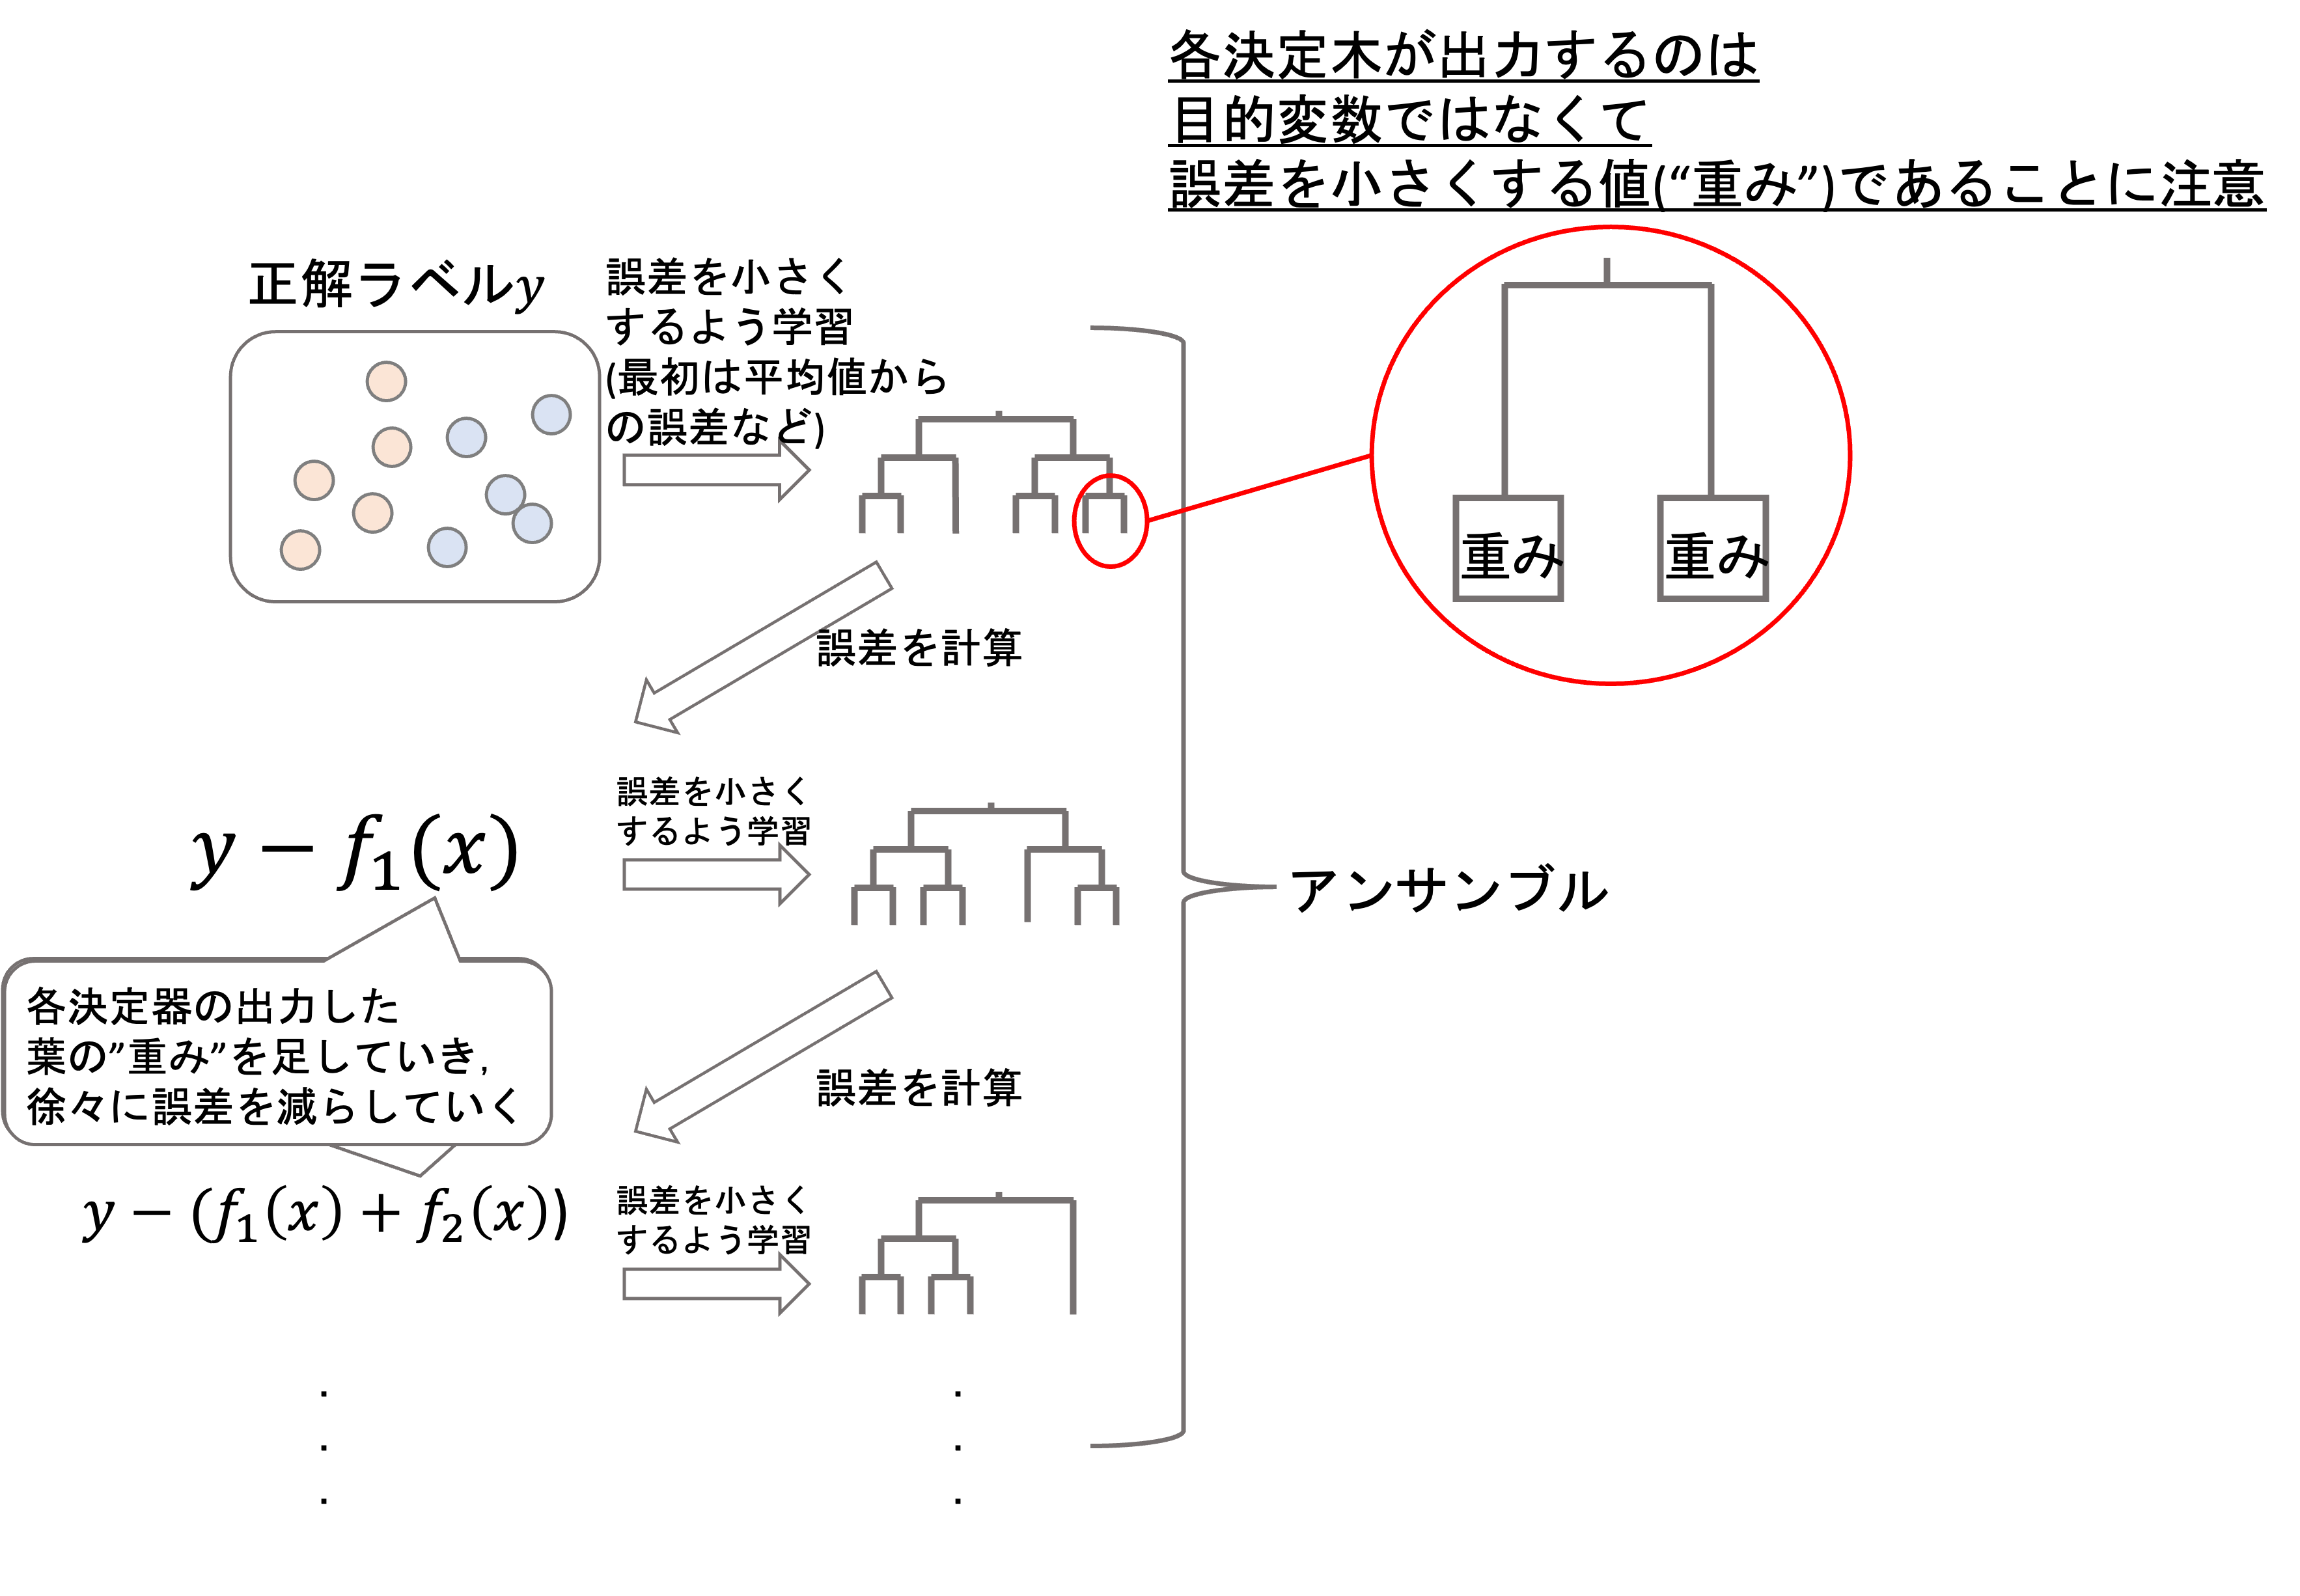

決定木の勾配ブースティングでは「勾配(=残差)」と名がある通り，各決定木では「残差」を学習していきます．

まず一つ目の決定木の出力結果と正解値の残差(𝑦𝑖−𝑓1(𝑥𝑖))を計算し，二つ目の決定木ではその残差を埋めるような値を学習します．（ただし各𝑡での学習データ𝑥𝑖の決定木の出力を𝑓𝑡(𝑥𝑖)とします．）

しかしそれでもまだ残差があるので，今度は一つ目の決定木と二つ目の決定木を足し合わせた値との残差(𝑦𝑖−(𝑓1(𝑥𝑖)+𝑓2(𝑥𝑖)))が埋まるような値を３つ目の決定木が学習していきます．

これを何度も繰り返して，全ての決定木の出力値にshrinkage係数(学習率)𝜂を足し合わせた∑𝐾𝑘=1𝜂𝑓𝑘(𝑥𝑖)を最終的な予測値𝑦𝑖^とするアルゴリズムがGBDT(決定木勾配ブースティング)です．(shrinkageについては前回を参照)

XGBoostもLightGBMもこのGBDTがベースとなっています．

## 高速化の手法

どうやって”Light”な決定木の勾配ブースティングを実現しているの？
それでは，LightGBMがどのようにこのGBDTのアルゴリズムを高速化しているのかについて解説します．

LightGBMは主に以下の仕組みを作って高速化を実現しています．細かい点は他にもあるのですが，本記事ではこれら４つのポイントについて解説をします．

    level wiseからleaf wise: 損失が最も減少するノードから分割をしていく
    histogram based: 連続値の特徴量をヒストグラム化し，bin単位で分割する
    Gradient-based One-Side Sampling (GOSS): 勾配が小さいデータはランダムサンプリングする
    Exclusive Feature Bundling (EFB): 複数の特徴量をbundleしてまとめて一つの特徴量のように扱う

特に後半の二つ(GOSSとEFB)が新しい手法としてLightGBMの研究成果になっています．

## leaf wise tree
決定木の作り方として，level wiseで作っていくのか，leaf wiseで作っていくのかの二通りがあります．

level wise (depth first): 左のノードから順に分割し，その階層の分割が全て終わったら次の階層に行くようにして決定木を構築していくやり方
leaf wise (best first): 最も損失が小さくなるようなノードから分割をしていくやり方

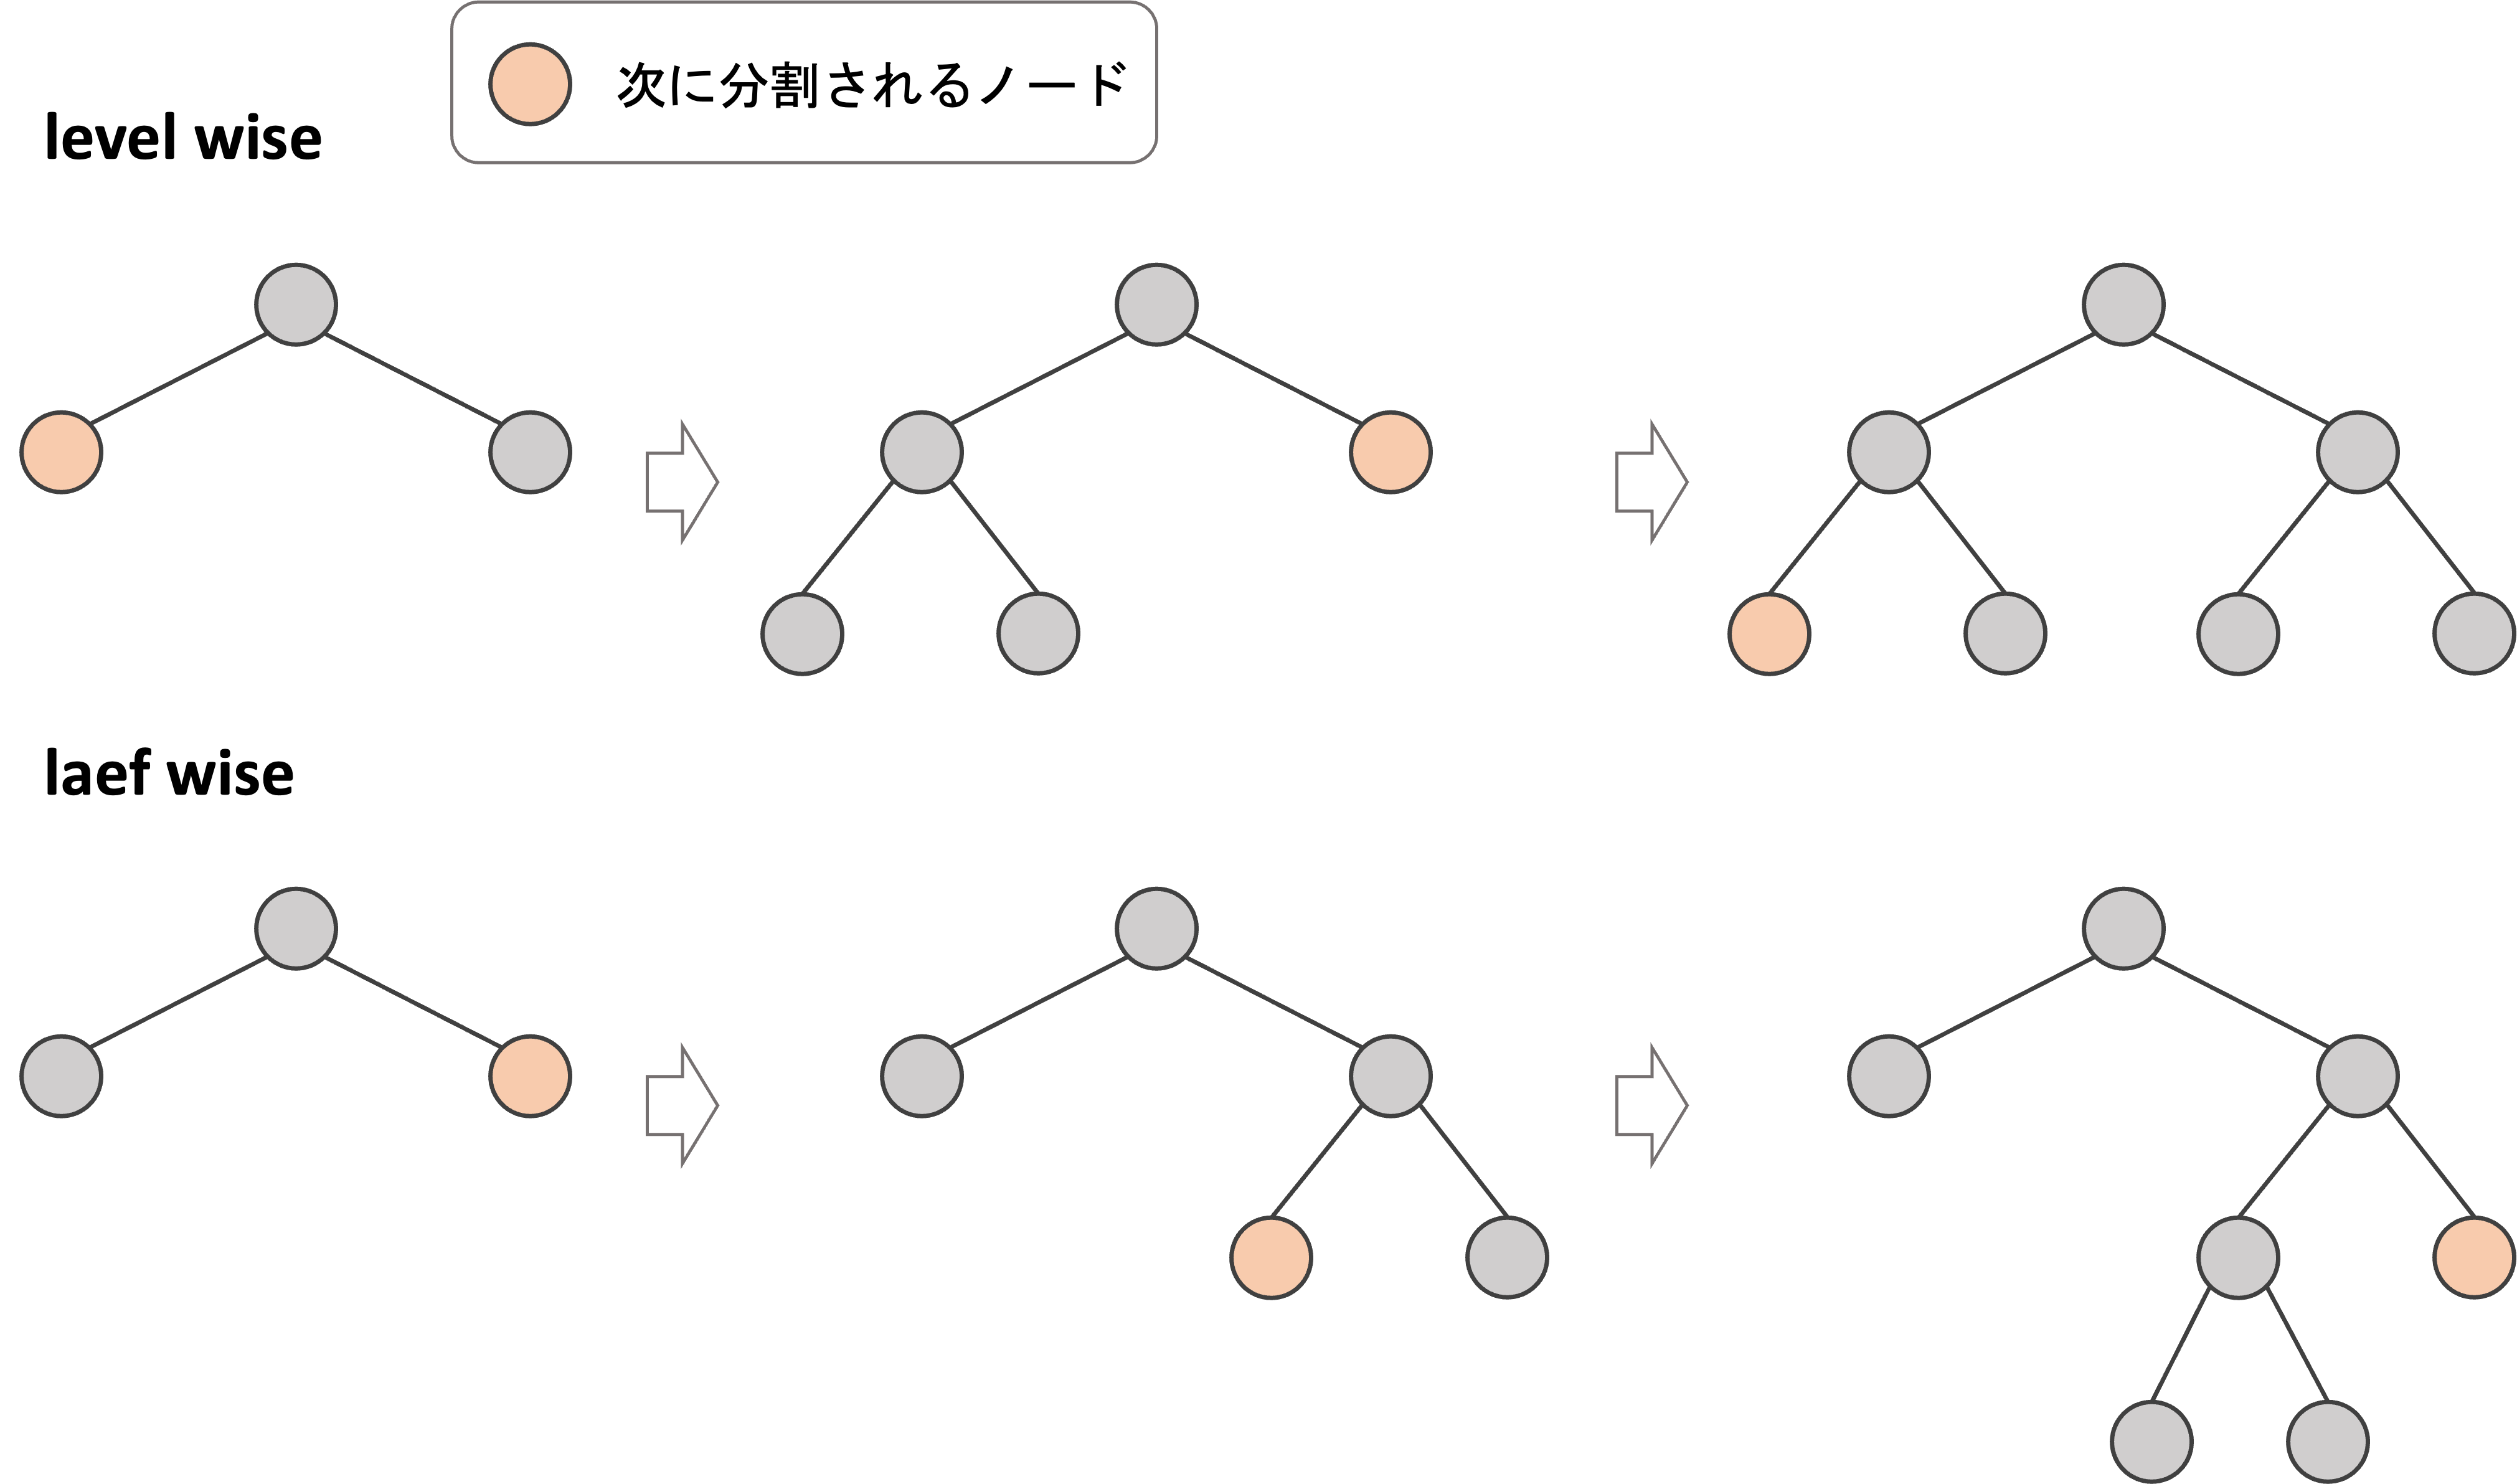

一般的な決定木のアルゴリズムはlevel wiseのやり方で決定木を作っていきます．どちらのやり方も最後まで決定木を作っていくと同じ決定木になることに注意してください．つまり，これらはただ分割の順番が変わるだけです．

ただ，最後まで決定木を作ってしまうと木が複雑になってしまい過学習になるので，普通は途中で分割をやめたり，分割しきってから一部の木を剪定するのが普通です．(これについては第29回でも述べましたね)

LightGBMではleaf wiseを採用し，途中で分割をやめます．(つまり，level wiseでやっていくのとは違う決定木ができるわけです)

leaf wiseを採用することで，ある程度精度がでる決定木をlevel wiseよりも早く構築することができます．(損失を下げるノードから優先的に分割していくので，理解しやすいかと思います．)

leaf wiseの方がlevel wiseに比べ過学習するのが早いので注意が必要ですが，データ数が多いと毎回のノードの分割で時間がかかってしまうので，leaf wiseで途中で分割を止める(early stopping)方が良いとされています．

## histogram based
histogram based algorithmという手法を使って，ノードを分割する際により高速に分割できるようにします．

通常，ノードを分割する際は，あらかじめソートされた値に対して一つ一つの分岐点において損失がどう変化するかでどこで分割するかを決めます．(pre-sorted algorithm)

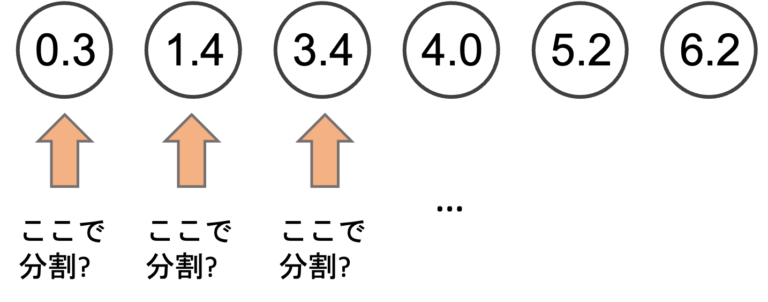

この場合，分割の計算量はデータ数を𝑚，特徴量数を𝑛とすると(𝑚×𝑛)となります．(それぞれの特徴量ごとに分割を試みるため)

## 補足
はビッグ・オー(Big O)記法と呼ばれるもので，計算量の関数です．例えばパラメータNに対して(𝑁2)とした場合，Nの2乗の速さで計算量が増えていくことを意味します．計算量についてはまたどこかで記事にします．
これは，データ数や特徴量数が多いとかなり時間がかかります．(一つの決定木ならともかく，ブースティングで複数の決定木を作るとなると大変です)

これを緩和するために，一つ一つの値を分岐点の候補にするのではなく，値をヒストグラム化し，いくつかの値を一つのbinにしてそのbinを分岐点の候補にすることによって高速化を狙います.これをhistogram based algorithmと呼びます．



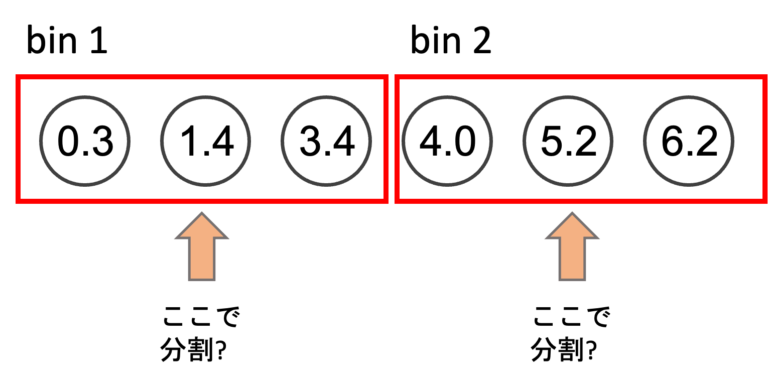

これにより，分岐点の探索にかかるコストはbinの数をn’とすると(𝑚×𝑛′)となり，当然𝑛′<<𝑛なので，pre-sorted よりも高速に分割することができるのです．

## Gradient-based One-Side Sampling (GOSS)

簡単にいうと，毎回の決定木の学習に使うデータを減らすことによって計算コストを下げる手法です．

どのようにするかというと，残差(勾配)が大きいデータはまだ学習できていないデータなので全て学習データとして使い，残差が小さいデータは既にある程度学習が済んでいると言えるので，ランダムサンプリングして一部のデータのみを学習データとして使います．

残差が大きい上位𝑎×100%はそのまま学習に使い，残りのデータから𝑏×100%をランダムサンプルししたデータのみ学習に使います．

以下のようなイメージです．

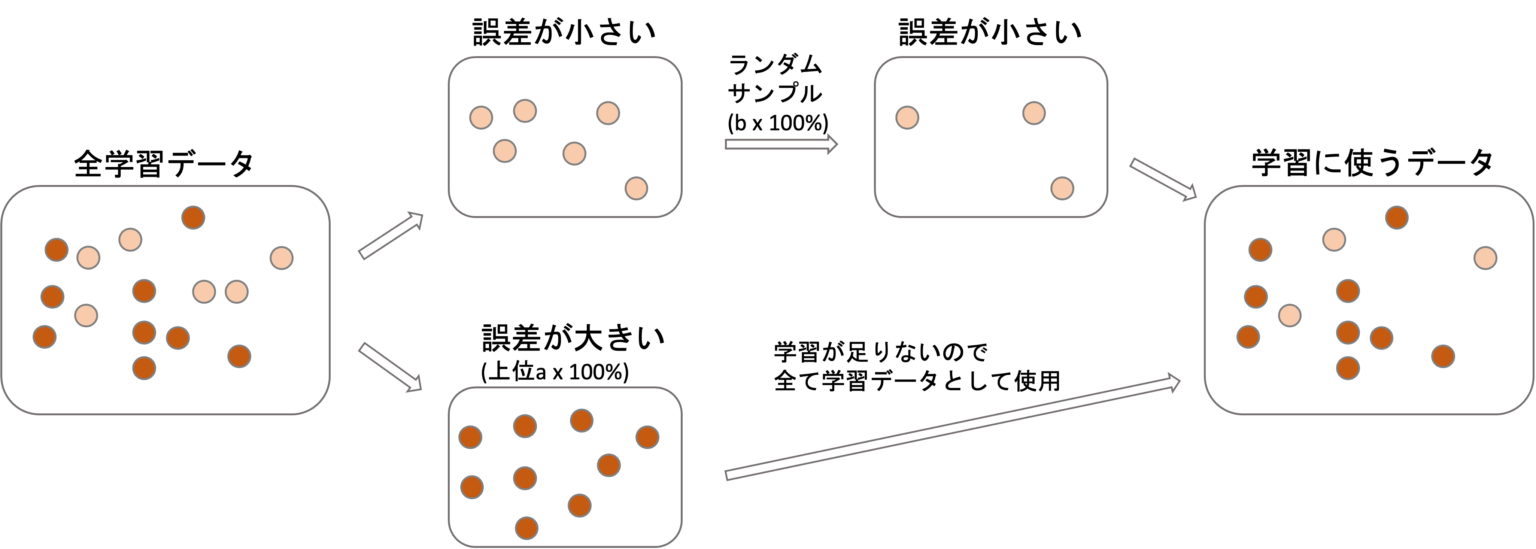

例えば全データが100個でa=0.5，b=0.7とすると，残差が大きい上位50%(=50個)のデータはそのまま学習データとして使用し，残りの50個のデータから70%(=35個)のデータをランダムサンプルします．

こうすることで学習データの数を減らし，高速化を目指しています．

また，分割時の損失を計算する際にランダムサンプルされたデータの値を1−𝑎𝑏倍します．これは，ランダムサンプリングしたことによって残差の総和が減ってしまうので，ランダムサンプリングの前の水準に戻しています．

## Exclusive Feature Bundling (EFB)

EFBは特徴量の数を実質的に減らすことを目的としています．

特徴量が多いデータというのは，欠損値が多いスカスカなデータであることが多いです．(このようなデータを”疎”なデータという意味でスパース(sparse)なデータと言います)

これを利用し，相互に排他的な（exclusiveな: 同時にゼロではない値を取らないような）複数の特徴量を一つのbundleにまとめてしまい，bundleを一つの特徴量として処理します．

補足
相互に排他的な特徴量とは，例えばone-hot vectorなどの[0, 0, 1, 0] のようにゼロでない値を同時に取らないようなものです．
ではどのように特徴量を一つのbundleにまとめるのかを解説します．（ここでは二つの特徴量を一つにまとめる例を紹介します）

１．まず，ゼロではない値が被る(=衝突する)データが一定数以下である特徴量同士を一つのbundle(束)とします．例えば以下は特徴量aとbを持つ６つのデータにおける衝突の例です．

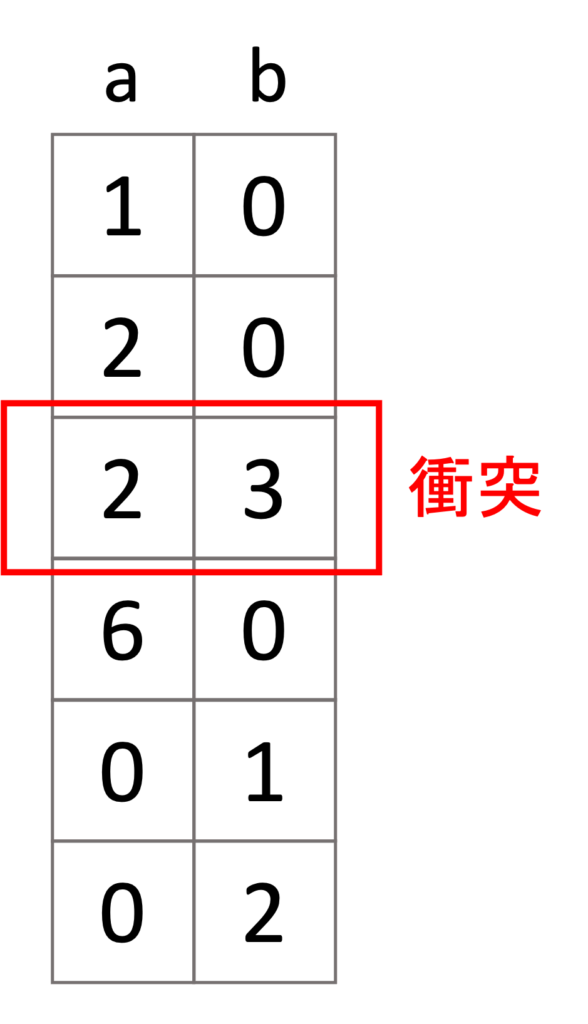

2. 同じbundleにある特徴量を，それぞれの特徴量が取る値の範囲が被らないように値をずらし一つの特徴量とします．

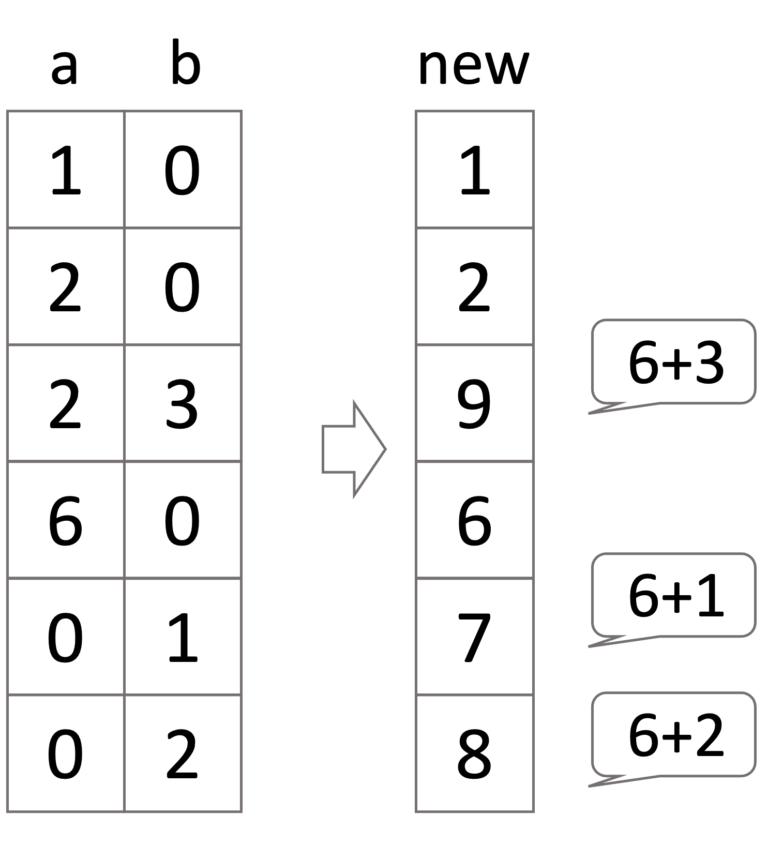

## 補足
衝突があるデータに対してどのように処理をしているかは分かりませんが，原論文のアルゴリズムを読む限り，後に処理した特徴量の値で上書いているようです．

## 補足
実際にはhistogram basedを適用するので，それぞれのデータの値ではなくてヒストグラムのbin単位でこれを行います．
このように特徴量の数𝑛をbundle数𝑛′(<𝑛)にすることによって計算コストを下げ，高速に処理できるようにしています．

## LightGBMの特徴
ここまで，LightGBMのアルゴリズムを見てきましたが，LightGBMはどういう特徴があるのかまとめておきます．

まず第一に，従来のGBDTに比べると学習スピードが早いです．また，ヒストグラムを使用することでメモリ効率も高くまさに「Lightな」GBDTであると言えます．

また，leaf wiseを採用していることで高い精度を期待できる一方，過学習しやすいアルゴリズムであることに注意しましょう．

精度を落とすことなく高速化を実現できたことで，PDCAを多く繰り返すことが可能になり最終的に高い精度のモデルを構築できるようになりました．

## PythonでLightGBMを実装する
それでは今回もPythonでLightGBMを使ってみます．

PythonでLightGBMを使うには，microsoftが中心にメンテナンスをしているLightGBMフレームワークを使用します．

scikit-learnにはないので，別途 $pip install lightgbm でインストールしてください．(jupyter noteで行う場合は % を頭につけて実行してください．)

インストールができたら import lightgbm でインポートできることを確認しておきましょう．

今回も前回の記事同様にタイタニックのデータセットを使います．(タイタニックデータについてはデータサイエンスのためのPython第11回を参照ください)

コードはほとんど前回の記事のものと同じです^^; xgboostモジュールと同じようにlightgbmモジュールを使うことができます．

## データ準備

In [1]:
import pandas as pd
import seaborn as sns

df = sns.load_dataset('titanic')
# df = df.dropna()
X = df.loc[:, (df.columns!='survived') & (df.columns!='alive')]
X = pd.get_dummies(X, drop_first=True)
y = df['survived']

XGBoost同様，LightGBMも欠損値を対処するアルゴリズムが織り込まれているので，欠損値に対しての処理は不要です．そのまま学習データとして使うことができます．
そして今回もこのデータセットを学習データとテストデータを7:3に分けます．

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

学習
それでは学習データに対してLightGBMを学習させてみます．分類器には lightgbm.LGBMClassifier ，回帰には lightgbm.LGBMRegressor クラスを使います． lightgbm は as を使って lgb としてインポートしましょう．

基本的な使い方は他のscikit-learnの機械学習モデルのクラスと同じで， model=lgb.LGBMClassifier() でインスタンスを生成して， model.fit(X_train, y_train) で学習をさせればOKです．

が，XGBoost同様色々とパラメータをセットできるので，よく使うものだけピックアップして簡単に解説します．

LGBMClassifier() のインスタンス生成時のパラメータは以下があります．

    n_estimators : ブースティングの回数(=学習する決定木の数)．デフォルトは100．
    boosting_type : ブースティングアルゴリズムを以下から選択．デフォルトは
     'gbdt'
     'gbdt' , 従来の Gradient Boosting Decision Tree.
     'dart' , Dropouts meet Multiple Additive Regression Trees.
     'goss' , Gradient-based One-Side Sampling (本記事で説明).
     'rf' , Random Forest.’
    learning_rate : shrinkageの𝜂．デフォルトは0.1
    max_depth : 決定木の最大の深さ．デフォルトではfull treeまで学習してしまうので，何か値を入れておくと◎
    random_state : 乱数のseed
    
他にも色々とありますが，まずはこのあたりのパラメータを押さえておけばOKです．

今回は以下のようにインスタンスを作っておきます

In [3]:
import lightgbm as lgb
model = lgb.LGBMClassifier(boosting_type='goss', max_depth=5, random_state=0)

.fit()のよく使う引数は以下です．

    eval_set : (X, y)のリストで，これを渡すと，ブースティング時の各イテレーションごとにこのデータセットを使って評価してくれる．
    callbacks  : 各イテレーションの際に実行するcallback関数のリスト(early stopping時に使用)

今回も前回の記事同様テストデータを各イテレーションで評価するデータとして使います.

また，early stoppingをするには callbacks 引数を使います． lgb.early_stopping() と lgb.log_evaluation() をリストにして callbacks 引数に入れてあげればOKです． lgb.log_evaluation() を callbacks に入れることで各イテレーション時に評価指標を出力してくれます．

最初は慣れないやり方かもしれませんが，深層学習などの学習をイテレーションで回していくアルゴリズムではよくある形です．この辺りは今後の深層学習講座でも詳しく書いていきたいと思います．

よくわからない方は，とりあえず形だけ覚えてしまってください． lgb.early_stopping() には stopping_rounds 引数に最低限ブースティングのイテレーションをする回数を入れます．

補足
xgboost同様， .fit() に verbose や early_stopping_rounds 引数を渡すことで同様のことができますが，将来これらは callbacks に置き換わるようです．


In [4]:
eval_set = [(X_test, y_test)]
callbacks = []
callbacks.append(lgb.early_stopping(stopping_rounds=10))
callbacks.append(lgb.log_evaluation())
model.fit(X_train, y_train, eval_set=eval_set, callbacks=callbacks)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 230, number of negative: 393
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tot

LGBMClassifier(boosting_type='goss', max_depth=5, random_state=0)

するとこのように各イテレーションの評価結果を出力してくれます．どうやら[40]のイテレーションの時損失が最小で,そこから10回( stopping_rounds=10 )イテレーションを回して学習が終了しています．(xgboost同様， .best_iteration_ と .best_score_ で確認できます．接尾辞の _ がついていることに注意しましょう)


## 予測と評価
他のsklearnの機械学習クラスと同様， .predict() や .predict_proba() で予測することができます． sklearn.metrics.log_loss で評価指標を計算して，イテレーション時の最小のloglossと一致することを確認しましょう．

In [5]:
from sklearn import metrics
y_pred = model.predict_proba(X_test)
metrics.log_loss(y_test, y_pred)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


0.411694250106446

## 補足
今回の例では，splitしたテストデータを検証データとして使ってearly stoppingをしましたが，この場合検証データに対して過学習となっていることに注意してください． 最終的なモデルとして相応しいかどうかは，kfoldCVで汎化性能を測って決めましょう．

## 学習曲線(learning curve)
lgb.plot_metric(model) で，簡単に学習曲線を描画することができます

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

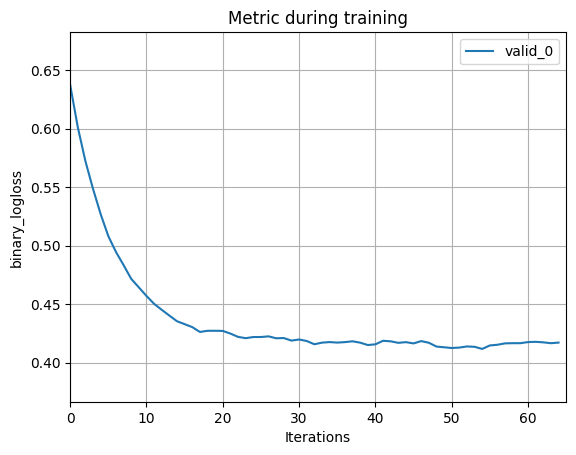

In [6]:
lgb.plot_metric(model)

学習曲線というのは，学習の各イテレーションで学習データや検証データの評価がどのように推移したかを示したものです．これを使ってパラメータをどのように変更すべきかを考えたりします．例えばあまりにも収束(損失が下がらなくなる状態)が早い場合，学習率を下げた方が良かったり，過学習気味であれば木をもう少し小さくするなどです．(過学習しているかどうかは学習データの学習曲線も必要です)

## 特徴量の重要度
XGBoost同様，LightGBMも特徴量の重要度を出すことができます． lgb.plot_importance(model) で簡単に描画してみましょう．

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

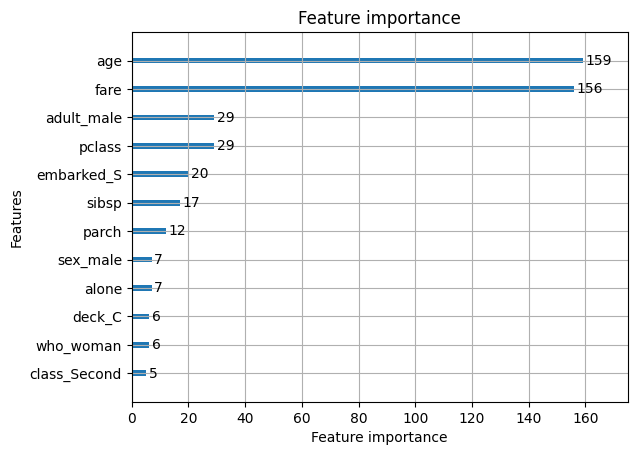

In [7]:
lgb.plot_importance(model)

重要度をみると，年齢や運賃，性別といった特徴量が上位にきているのが分かります．乗客の生死を分けた要素としては納得できるかと思います．

今回もかなり長くなってしまいましたね．．．．この辺りでまとめていきます！

まとめ
今回は巷で”最強”と謳われるLightGBMについて解説をしました．(今回もかなりの長文記事になってしましましたね・・・

    LightGBMはXGBoostを超えるとも言われる最強アルゴリズムの一つ
    LightGBMはXGBoost同様，決定木の勾配ブースティングアルゴリズムの一つ
    LightGBMは高速に決定木を構築する工夫を施している

    工夫している点は主に4点;
    leaf wise algorithm: 最も損失を下げるノードから分割していくことで早く精度を上げることができる
    histogram based algorithm: 連続値の値をヒストグラム化しbinのレベルで分岐することで，分岐点の候補を減らし高速化を実現
    Gradient-based One-Side Sampling (GOSS): 勾配(残差)の小さいデータはランダムサンプリングすることによって学習データを減らし高速化を実現
    Exclusive Feature Bundling (EFB): 相互に排他的な特徴量同士を一つのbundle(束)にすることで実質的に特徴量を減らし高速化を実現
    こんな感じです！かなりの量になってしまいましたが，やってることはそんなに難しいことではなくアルゴリズム自体も割と理解できるレベルかと思います！

LightGBMはKaggleなどのコンペの上位モデル常連のアルゴリズムなので，高精度を目指すなら必須のアルゴリズムと言えるでしょう．しかし，比較的新しいアルゴリズムであることもあり，あまり包括的に解説している記事はかなり少ないように思えます．

是非今回の記事が学習の一助になれば幸いです．さらに理論を勉強したい人は是非論文を読んでみてください！